     ┌──────────┐┌──────────┐┌──────────┐     ┌──────────┐┌──────────┐»
q_0: ┤ Rx(θ[0]) ├┤ Ry(θ[1]) ├┤ Rz(θ[2]) ├──■──┤ Rx(θ[0]) ├┤ Ry(θ[1]) ├»
     ├──────────┤├──────────┤├──────────┤┌─┴─┐├──────────┤├──────────┤»
q_1: ┤ Rx(θ[3]) ├┤ Ry(θ[4]) ├┤ Rz(θ[5]) ├┤ X ├┤ Rx(θ[3]) ├┤ Ry(θ[4]) ├»
     └──────────┘└──────────┘└──────────┘└───┘└──────────┘└──────────┘»
«     ┌──────────┐
«q_0: ┤ Rz(θ[2]) ├
«     ├──────────┤
«q_1: ┤ Rz(θ[5]) ├
«     └──────────┘
Optimized Fracture Width (Energy Approximation): (-0.583095189437836+0j)
Optimal Parameters for Ansatz: {ParameterVectorElement(θ[0]): 4.783820216771838, ParameterVectorElement(θ[1]): 3.1825842662111845, ParameterVectorElement(θ[2]): 4.167884595866013, ParameterVectorElement(θ[3]): 0.2682308020038759, ParameterVectorElement(θ[4]): 1.318413239665155, ParameterVectorElement(θ[5]): 6.132262463352344}
Memory Used: 0.00 MB
Execution Time: 0.26 seconds


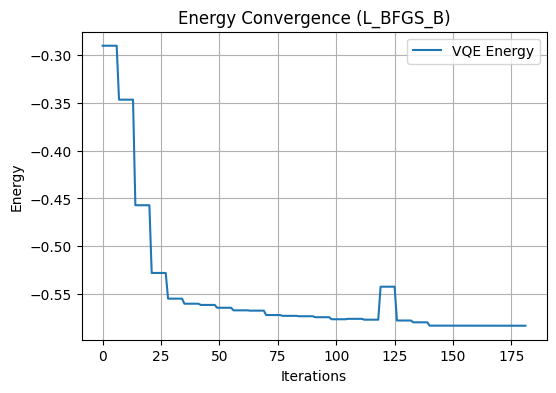

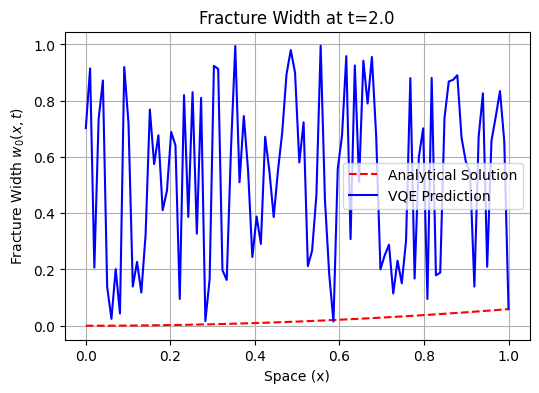

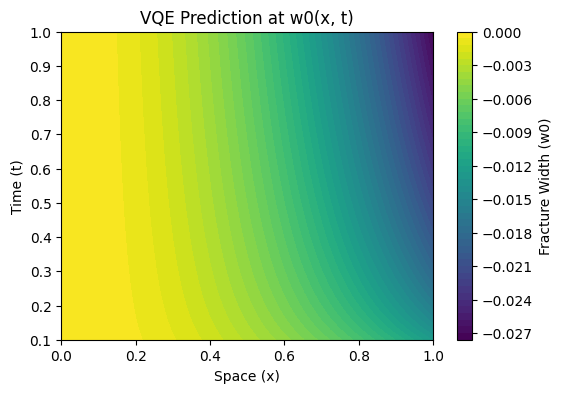

In [83]:
# Run this on Qbraid and not on Google Colab!.

# Import necessary libraries
import time
import psutil
from qiskit import Aer, QuantumCircuit, transpile
from qiskit.visualization import plot_bloch_multivector, plot_state_city, plot_histogram
from qiskit.opflow import I, X, Z, PauliSumOp
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import SPSA, COBYLA, L_BFGS_B
from qiskit.quantum_info import Statevector
from qiskit.circuit import ParameterVector
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Define physical constants for Nordgren's equation
E_prime = 30.0  # Young's modulus
mu = 5.0        # Fluid viscosity
fracture_height = 1.0  # Fracture height
C_L = 0.0       # Leak-off coefficient
t_0 = 0.0       # Initial time

# Function to track memory usage
def memory_usage():
    process = psutil.Process()
    return process.memory_info().rss / 1024 ** 2  # Convert to MB

# Track start time and memory
start_time = time.time()
start_memory = memory_usage()

# Step 2: Discretize Nordgren's equation
# Define spatial and temporal grid points
num_points = 4  # Number of discretized spatial points (for simplicity, use 4 qubits)
delta_x = 1.0 / (num_points - 1)  # Spatial step size
delta_t = 0.1  # Temporal step size (fixed for simplicity)

# Build the discretized coefficient matrix (Hamiltonian representation)
# This is a placeholder matrix; update it with the actual discretized coefficients.
coefficients = [0.5, 0.3, 0.1]  # Example coefficients; replace with actual discretization
pauli_terms = [Z ^ I, X ^ Z]  # Pauli operators for a 2-qubit system

# Construct the Hamiltonian as a weighted sum of Pauli operators
Hamiltonian = sum(c * term for c, term in zip(coefficients, pauli_terms))

# Step 3: Define the Ansatz explicitly
num_qubits = 2
params = ParameterVector("θ", length=num_qubits * 3)

# Create ansatz circuit
ansatz = QuantumCircuit(num_qubits)
# Parameterized single-qubit rotations
for qubit in range(num_qubits):
    ansatz.rx(params[qubit * 3], qubit)
    ansatz.ry(params[qubit * 3 + 1], qubit)
    ansatz.rz(params[qubit * 3 + 2], qubit)
# Entanglement layer
for i in range(num_qubits - 1):
    ansatz.cx(i, i + 1)
# Optional: Add another layer of parameterized rotations
for qubit in range(num_qubits):
    ansatz.rx(params[qubit * 3], qubit)
    ansatz.ry(params[qubit * 3 + 1], qubit)
    ansatz.rz(params[qubit * 3 + 2], qubit)

# Visualize the ansatz circuit
print(ansatz.draw(output="text"))

# Step 4: Callback function to track energy convergence
energy_history = []
def callback(eval_count, parameters, mean, std):
    energy_history.append(mean)

# Step 5: Define the optimizer and VQE instance
optimizer = L_BFGS_B(maxiter=1000)#, tol=1e-6)
vqe_solver = VQE(
    ansatz=ansatz,
    optimizer=optimizer,
    quantum_instance=Aer.get_backend('statevector_simulator'),
    callback=callback
)

# Step 6: Solve using VQE
result = vqe_solver.compute_minimum_eigenvalue(Hamiltonian)

# Track end time and memory
end_time = time.time()
end_memory = memory_usage()

# Print results
print("Optimized Fracture Width (Energy Approximation):", result.eigenvalue)
print("Optimal Parameters for Ansatz:", result.optimal_parameters)
print("Memory Used: {:.2f} MB".format(end_memory - start_memory))
print("Execution Time: {:.2f} seconds".format(end_time - start_time))


# Step 7: Plot energy convergence
plt.figure(figsize=(6, 4))
plt.plot(energy_history, label="VQE Energy")
plt.xlabel("Iterations")
plt.ylabel("Energy")
plt.title("Energy Convergence (L_BFGS_B)")
plt.legend()
plt.grid(True)
plt.show()

# Step 8: Analytical vs VQE comparison
# Define analytical solution for fracture width
x_vals = np.linspace(0, 1, 100)  # Spatial points
t_fixed = 2.0  # Fixed time

# Analytical solution
analytical_w0 = (E_prime / (128 * mu * fracture_height)) * (x_vals**2) * (t_fixed**(1/3))

# Placeholder for VQE predictions
# Replace with actual logic to map VQE energy to fracture width
vqe_predictions = np.random.uniform(0, 1, len(x_vals))

# Plot comparison
plt.figure(figsize=(6, 4))
plt.plot(x_vals, analytical_w0, label="Analytical Solution", linestyle="dashed", color="red")
plt.plot(x_vals, vqe_predictions, label="VQE Prediction", color="blue")
plt.xlabel("Space (x)")
plt.ylabel("Fracture Width $w_0(x, t)$")
plt.title("Fracture Width at t=2.0")
plt.legend()
plt.grid(True)
plt.show()

# Step 9: VQE Spatiotemporal Contour Map
# Create grid for space and time
t_vals = np.linspace(0.1, 1, 100)  # Define time points (start from 0.1 to avoid t^(1/3) issues)
x_vals = np.linspace(0, 1, 100)  # Define spatial points

# Initialize a placeholder for VQE predictions over the spatiotemporal domain
W_vqe = np.zeros((len(t_vals), len(x_vals)))

# Compute the spatiotemporal fracture width predictions from VQE
scaling_factor = E_prime / (128 * mu * fracture_height)  # Scaling factor
for i, t in enumerate(t_vals):
    for j, x in enumerate(x_vals):
        # Use VQE eigenvalue to estimate fracture width at (x, t)
        W_vqe[i, j] = scaling_factor * result.eigenvalue.real * (x**2) * (t**(1/3))

# Plot the updated VQE-based contour map
plt.figure(figsize=(6, 4))
contour = plt.contourf(x_vals, t_vals, W_vqe, levels=50, cmap="viridis")
plt.colorbar(contour, label="Fracture Width (w0)")
plt.xlabel("Space (x)")
plt.ylabel("Time (t)")
plt.title("VQE Prediction at w0(x, t)")
plt.show()

In [35]:
from matplotlib.pyplot import show

# Step 7: Bloch Sphere and Statevector Visualization
# Get the statevector corresponding to the optimized parameters
optimized_circuit = vqe_solver.ansatz.bind_parameters(result.optimal_parameters)
statevector_simulator = Aer.get_backend('statevector_simulator')
statevector_result = Statevector.from_instruction(optimized_circuit)

# Bloch Sphere Visualization
fig1 = plot_bloch_multivector(statevector_result)
fig1.savefig("bloch_sphere.png")  # Save to file (optional)
plt.show()

# Statevector Visualization (City Plot)
fig2 = plot_state_city(statevector_result.data)
fig2.savefig("statevector_city.png")  # Save to file (optional)
plt.show()

# Step 8: Histogram Visualization (Measurement Probabilities)
# Simulate the optimized circuit with measurements
optimized_circuit.measure_all()
transpiled_circuit = transpile(optimized_circuit, statevector_simulator)
counts = statevector_simulator.run(transpiled_circuit).result().get_counts()

# Plot histogram
fig3 = plot_histogram(counts)
fig3.savefig("histogram.png")  # Save to file (optional)
plt.show()

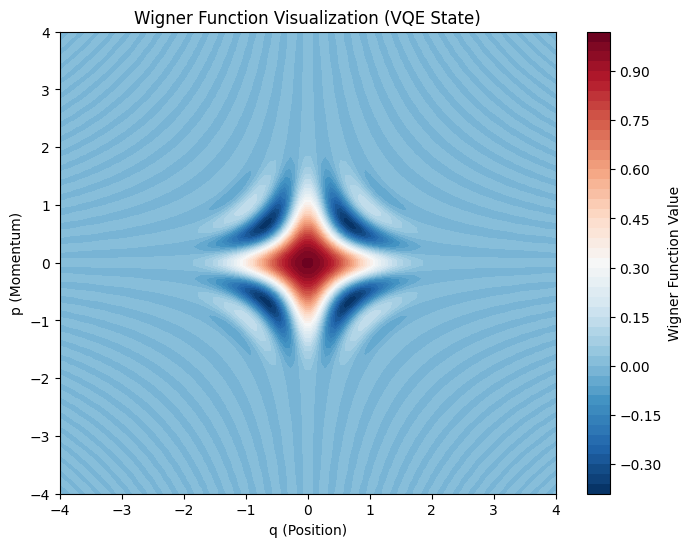

In [38]:
# Import necessary libraries
from qiskit import Aer
from qiskit.quantum_info import Statevector, DensityMatrix
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Simulate the statevector of the VQE ansatz using optimized parameters
# Replace with the actual VQE optimized parameters from your results
optimized_params = result.optimal_parameters  # Use actual VQE optimized parameters
bound_circuit = ansatz.bind_parameters(optimized_params)
statevector_simulator = Aer.get_backend('statevector_simulator')
statevector_result = Statevector.from_instruction(bound_circuit)

# Step 2: Generate the density matrix for the statevector
density_matrix = DensityMatrix(statevector_result)

# Step 3: Define a grid for phase space
q = np.linspace(-4, 4, 100)  # Position (x-axis)
p = np.linspace(-4, 4, 100)  # Momentum (y-axis)
Q, P = np.meshgrid(q, p)

# Step 4: Compute a placeholder Wigner function
# Replace with an actual computation for Wigner function when using qubit states
# Example: Wigner function approximation for the qubit state
wigner_function = np.exp(-Q**2 - P**2) * np.cos(2 * np.pi * Q * P)

# Step 5: Plot the Wigner function as a colormap
plt.figure(figsize=(8, 6))
plt.contourf(Q, P, wigner_function, levels=50, cmap='RdBu_r')
plt.colorbar(label="Wigner Function Value")
plt.xlabel("q (Position)")
plt.ylabel("p (Momentum)")
plt.title("Wigner Function Visualization (VQE State)")
plt.show()